## Libraries

In [1]:
import gc
import os
import sys
import time
import random
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision as vision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

from pathlib import Path
from PIL import Image
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')

from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook
from fastprogress import master_bar, progress_bar

from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

In [2]:
def seed_torch(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=1234)

In [3]:
def get_logger():
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    # handler1
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # handler2
    handler2 = FileHandler(filename=dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".log")
    handler2.setFormatter(Formatter("%(asctime)s %(levelname)8s %(message)s"))
    # addHandler
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

## Csv Loading

In [4]:
!ls ../input/imet-2019-fgvc6/

labels.csv  sample_submission.csv  test  train	train.csv


In [5]:
labels = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")
train = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
sample = pd.read_csv("../input/imet-2019-fgvc6/sample_submission.csv")
train.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [6]:
print(labels.attribute_id.nunique())
labels.head()

1103


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [7]:
!ls ../input/imet-my-pretrained-models/

resnet18_0.562.pth


## DataLoader

In [8]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms["test"] = data_transforms["val"]

# Without KFold, We won't use data_transforms["val"] this time...
# We will use data_transforms["train"] for "..input/train" folders, data_transforms["test"] for "..input/test" folders

In [9]:
class IMetDataset(data.Dataset):
    def __init__(self, datafolder, datatype='train', index=[], device="cuda:0",
                 transform=transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), 
                 labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.index = index
        self.device = device
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train' or self.datatype == 'val':
            if self.index==[]:
                self.image_files_list = [s for s in os.listdir(datafolder)]
                #self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
            else:
                self.image_files_list = np.array([s for s in os.listdir(datafolder)])[index]
                #self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.image_files_list = [s for s in os.listdir(datafolder)]
            #self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        
    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]
        if self.datatype == 'train' or self.datatype == 'val':
            label = self.labels_dict[img_name_short]
            # Target has some labels, So we need to change labels to tensor
            label_tensor = torch.zeros((1, 1103))
            for i in label:
                label_tensor[0, int(i)] = 1
            label_tensor = label_tensor.to(self.device)
            return image, label_tensor
        else:
            label = 0
            return image, label

## Predictioner

In [10]:
class Predictioner:
    def __init__(self, model, valid_batch=128, seed=1234, 
                 device="cuda:0", load_model_name="best_model.pth"):
        self.model = model
        self.load_model_name = load_model_name
        self.valid_batch = valid_batch
        self.seed = seed
        self.device = device

    def val(self, val_idx, img_class_dict):
        # valid loader
        valid_dataset = IMetDataset(datafolder='../input/imet-2019-fgvc6/train/', 
                                    datatype='val', 
                                    index=val_idx, 
                                    transform=data_transforms["val"], 
                                    labels_dict=img_class_dict)
        loader = data.DataLoader(valid_dataset,
                                 batch_size=self.valid_batch,
                                 shuffle=False)
        # model
        model = self.model
        # load model pth
        model.load_state_dict(torch.load(self.load_model_name))
        model.to(self.device)
        model.eval()
        valid_preds = np.zeros((len(loader.dataset), 1103))
        valid_y = np.zeros((len(loader.dataset), 1103))
        avg_val_loss = 0.0
        for i, (i_batch, y_batch) in enumerate(loader):
            with torch.no_grad():
                y_pred = model(i_batch.cuda()).detach()
                y_batch = y_batch.view(y_batch.size()[0], -1) # flatten y_batch
                #avg_val_loss += self.loss_fn(y_pred, y_batch).item() / len(loader)
                if i_batch.size()[0]==self.valid_batch:
                    valid_preds[i * self.valid_batch : (i+1) * self.valid_batch] = y_pred.cpu().numpy()
                    valid_y[i * self.valid_batch : (i+1) * self.valid_batch] = y_batch.cpu().numpy()
                else:
                    valid_preds[len(loader.dataset) - i_batch.size()[0] : ] = y_pred.cpu().numpy()
                    valid_y[len(loader.dataset) - i_batch.size()[0] : ] = y_batch.cpu().numpy()
        return valid_preds, valid_y#, avg_val_loss
    
    def predict(self, loader):
        model = self.model
        # load model pth
        model.load_state_dict(torch.load(self.load_model_name))
        model.to(self.device)
        model.eval()
        preds = np.zeros((len(loader.dataset), 1103))
        for i, (i_batch, _) in enumerate(loader):
            with torch.no_grad():
                y_pred = model(i_batch.cuda()).detach()
                if i_batch.size()[0]==self.valid_batch:
                    preds[i * self.valid_batch : (i+1) * self.valid_batch] = y_pred.cpu().numpy()
                else:
                    preds[len(loader.dataset) - i_batch.size()[0] : ] = y_pred.cpu().numpy()
        return preds

## Model

In [11]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [12]:
model_conv = resnet18(pretrained=False)

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
    def forward(self, x):
        return x

num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 1103)
model_conv.fc = Classifier()

In [14]:
# MLP
mlp = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),
    nn.ReLU(),
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.25),
    nn.Linear(num_ftrs, 1103)
)

In [15]:
net = nn.Sequential(
    model_conv,
    mlp,
    nn.Sigmoid()
)

# Training

In [16]:
predictioner = Predictioner(net, valid_batch=128, seed=1234, device="cuda:0", 
                            load_model_name="../input/imet-my-pretrained-models/resnet18_0.562.pth")

In [17]:
# indices for validation
tr, val = train_test_split(train.id, test_size=0.2, random_state=1234)
tr, val = tr.index, val.index
#tr, val = list(tr), list(val)
# X_train, y_train, X_val, y_val
img_class_dict = {k:v for k, v in zip(train.id, train.attribute_ids.map(lambda x: x.split()).values)}

In [18]:
valid_preds, valid_y = predictioner.val(val, img_class_dict)

## Post process - threshold search -

In [19]:
def threshold_search(y_pred, y_true):
    score = []
    candidates = np.arange(0, 0.4, 0.01)
    for th in progress_bar(candidates):
        yp = (y_pred > th).astype(int)
        score.append(fbeta_score(y_pred=yp, y_true=y_true, beta=2, average="samples"))
    score = np.array(score)
    pm = score.argmax()
    best_th, best_score = candidates[pm], score[pm]
    plt.plot(candidates, score)
    plt.vlines(x=best_th, ymin=score.min(), ymax=score.max())
    plt.text(best_th+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
    plt.show()
    return best_th, best_score

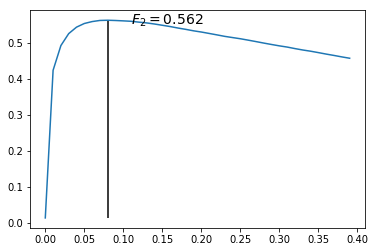

In [20]:
best_threshold, best_score = threshold_search(valid_preds, valid_y)

## Prediction for test data

In [21]:
# test loader
test_dataset = IMetDataset(datafolder='../input/imet-2019-fgvc6/test/', 
                           datatype='test', 
                           transform=data_transforms["test"])
test_loader = data.DataLoader(test_dataset,
                              batch_size=128,
                              shuffle=False)

In [22]:
test_preds = predictioner.predict(test_loader)

In [23]:
preds = (test_preds > best_threshold).astype(int)

In [24]:
pred_df = pd.DataFrame({"id": [i.split('.')[0] for i in os.listdir('../input/imet-2019-fgvc6/test/')]})
prediction = []
for i in range(preds.shape[0]):
    pred1 = np.argwhere(preds[i] == 1.0).reshape(-1).tolist()
    pred_str = " ".join(list(map(str, pred1)))
    prediction.append(pred_str)

pred_df["attribute_ids"] = prediction
submission = pd.DataFrame(sample["id"]).merge(pred_df, on="id", how="left")
submission.to_csv("submission.csv", index=False)
submission.head()

,id,attribute_ids
0,10023b2cc4ed5f68,195 223 289 344 369 587 766 1039 1059
1,100fbe75ed8fd887,231 1039
2,101b627524a04f19,79 263 420 498 784
3,10234480c41284c6,13 147 553 738 776 830 1006 1046
4,1023b0e2636dcea8,147 283 322 584 698 813 896 954 1046 1092
